In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import nltk
import pickle
import string
import seaborn as sns
sns.set_theme(style="darkgrid")

from scipy import sparse

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

## Uploading data

In [2]:
train = pd.read_csv(r'disaster_tweets/data/train.csv')
test = pd.read_csv(r'disaster_tweets/data/test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


## Data Preparation

<BarContainer object of 2 artists>

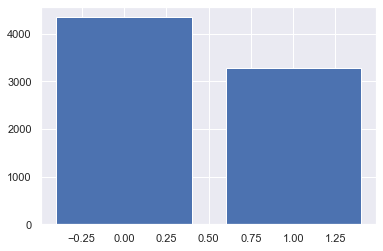

In [4]:
plt.bar(train['target'].value_counts().index, train['target'].value_counts().values)

The ratio of classes.

In [5]:
train['target'].value_counts()[1] / train['target'].value_counts()[0]

0.7533394748963611

### Analyzing 'keyword' and 'location' columns for missing values and outliers.

In [6]:
 train['location'].value_counts(dropna=False)

NaN                         2533
USA                          104
New York                      71
United States                 50
London                        45
                            ... 
teh internets                  1
Zimbabwe                       1
Galveston, Texas               1
wny                            1
Palm Bay, FL (Kissimmee)       1
Name: location, Length: 3342, dtype: int64

In [7]:
 train['keyword'].value_counts(dropna=False)

NaN                      61
fatalities               45
armageddon               42
deluge                   42
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

**There are a lot of NaNs**

In [8]:
train_for_plot = train.fillna('NOINFO')

In [9]:
locations = train_for_plot['location'].value_counts(dropna=False)
freq_locations = list(locations.index)

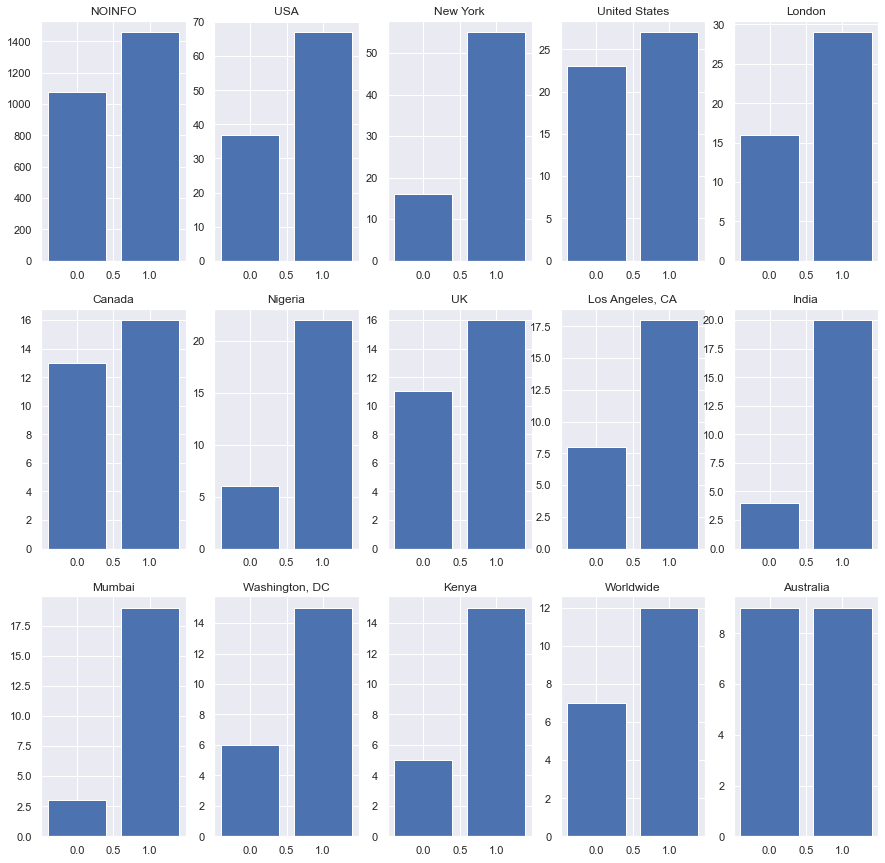

In [10]:
fig, ax = plt.subplots(3, 5, figsize=(15, 15))
for i in range(3):
    for j in range(5):
        temp_data = train_for_plot[(train_for_plot['location'] == freq_locations[i*5 + j])]
        ax[i][j].set_title(freq_locations[i*5 + j])
        ax[i][j].bar([1, 0], temp_data['target'].value_counts().values)

In [11]:
frames = [train, test]
full_data = pd.concat(frames)

In [12]:
locs = full_data['location'].value_counts(dropna=True)

In [13]:
locations_nan = locs[locs > 8]
print(locations_nan.index)

Index(['USA', 'New York', 'United States', 'London', 'Canada', 'Nigeria',
       'India', 'Worldwide', 'Los Angeles, CA', 'UK', 'Kenya',
       'Washington, DC', 'Mumbai', 'United Kingdom', 'Australia', 'California',
       'Los Angeles', 'Chicago, IL', 'San Francisco', 'New York, NY',
       'Florida', 'NYC', 'California, USA', 'San Francisco, CA', 'Chicago',
       'Toronto', 'Washington, D.C.', 'Ireland', 'Indonesia', 'Everywhere',
       'ss', 'Seattle', 'Philippines', 'Seattle, WA', 'Atlanta, GA',
       'New York City', 'Singapore', 'London, UK', 'Earth', 'Texas',
       'Manchester', 'World', 'Nashville, TN', 'Denver, CO', 'London, England',
       'Denver, Colorado', 'Dallas, TX', 'Memphis, TN',
       'Paterson, New Jersey ', 'Calgary, Alberta', 'Melbourne, Australia',
       'San Diego, CA', '304', 'Colorado', 'US', 'Houston, TX',
       'Sacramento, CA', 'Pennsylvania, USA', ' Road to the Billionaires Club',
       'worldwide', 'Scotland', 'Lagos', 'Planet Earth', 'Sydney', 

Replacing incorrect location names in test and train datasets

In [14]:
def change_location(dataset, name='dataset'):
    dataset['location'] = dataset['location'].replace('United States', 'USA')
    dataset['location'] = dataset['location'].replace('US', 'USA')
    dataset['location'] = dataset['location'].replace('Worldwide', 'Anywhere')
    dataset['location'] = dataset['location'].replace('worldwide', 'Anywhere')
    dataset['location'] = dataset['location'].replace('Everywhere', 'Anywhere')
    dataset['location'] = dataset['location'].replace('California, USA', 'California')
    dataset['location'] = dataset['location'].replace('United Kingdom', 'UK')
    dataset['location'] = dataset['location'].replace('San Francisco, CA', 'San Francisco')
    dataset['location'] = dataset['location'].replace('Chicago, IL', 'Chicago')
    dataset['location'] = dataset['location'].replace('New York, NY', 'New York')
    dataset['location'] = dataset['location'].replace('Los Angeles, CA', 'Los Angeles')
    dataset['location'] = dataset['location'].replace('NYC', 'New York')
    dataset['location'] = dataset['location'].replace('New York City', 'New York')
    dataset['location'] = dataset['location'].replace('Earth', 'Anywhere')
    dataset['location'] = dataset['location'].replace('ss', 'Anywhere')
    dataset['location'] = dataset['location'].replace('304', 'Anywhere')
    dataset['location'] = dataset['location'].replace('World', 'Anywhere')
    dataset['location'] = dataset['location'].replace('??????', 'Anywhere')
    dataset['location'] = dataset['location'].replace('Planet Earth', 'Anywhere')
    dataset['location'] = dataset['location'].replace('Washington, D.C.', 'Washington, DC')
    dataset['location'] = dataset['location'].replace('Denver, Colorado', 'Denver')
    dataset['location'] = dataset['location'].replace('Denver, CO', 'Denver')
    dataset['location'] = dataset['location'].replace(' Road to the Billionaires Club', 'Anywhere')
    dataset['location'] = dataset['location'].replace('Pennsylvania, USA', 'Pennsylvania')
    dataset['location'] = dataset['location'].replace('Paterson, New Jersey', 'Paterson')
    locations = dataset['location'].value_counts(dropna=True)
    anywhere_locations = locations[locations <= 8]
    for loc in list(anywhere_locations.index):
        dataset['location'] = dataset['location'].replace(loc, 'noinfo')
    dataset['location'].fillna('noinfo', inplace=True)
    
    
change_location(train, 'train')
change_location(test, 'test')
frames = [train, test]
full_data = pd.concat(frames)
print(full_data['location'].value_counts())

noinfo             9632
USA                 216
New York            165
Anywhere            138
UK                   59
London               58
Los Angeles          58
Washington, DC       47
California           46
San Francisco        43
Canada               42
Nigeria              40
Chicago              40
India                35
Kenya                32
Mumbai               22
Australia            18
Denver               16
Florida              14
Indonesia            13
Ireland              12
Toronto              12
Pennsylvania         12
Seattle              11
Texas                10
London, UK           10
London, England      10
Atlanta, GA          10
Sacramento, CA       10
Manchester            9
San Diego, CA         9
Dallas, TX            9
Nashville, TN         9
Philippines           9
Name: location, dtype: int64


In [15]:
keywords = train_for_plot['keyword'].value_counts(dropna=False)
keywords

NOINFO                   61
fatalities               45
armageddon               42
deluge                   42
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

Top 150 keyword for target values

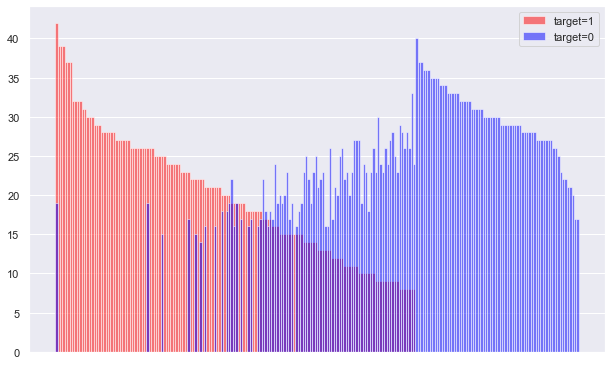

In [16]:
top = 150


fig= plt.figure(figsize=(10,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.xticks(rotation=90)
axes.get_xaxis().set_visible(False)
plt.bar(train_for_plot[train_for_plot['target'] == 1]['keyword'].value_counts().index[:top],
        train_for_plot[train_for_plot['target'] == 1]['keyword'].value_counts().values[:top],
         width=1, alpha=0.5, color='red', label='target=1')
plt.bar(train_for_plot[train_for_plot['target'] == 0]['keyword'].value_counts().index[:top],
        train_for_plot[train_for_plot['target'] == 0]['keyword'].value_counts().values[:top],
        width=1, alpha=0.5, color='blue', label='target=0')
plt.legend()

Top 40 keywords for each target value:

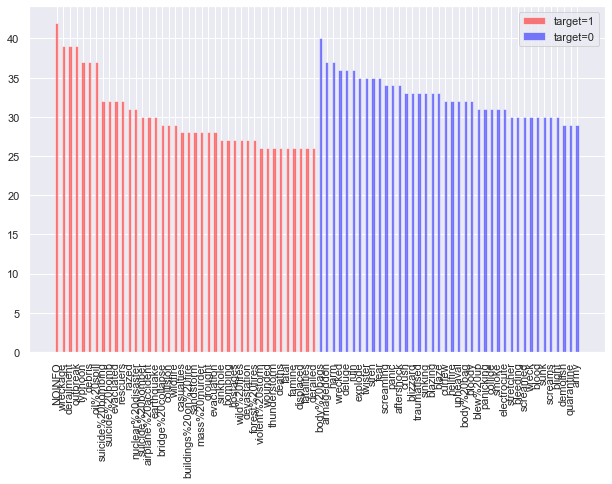

In [17]:
top = 40
fig= plt.figure(figsize=(10,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.xticks(rotation=90)
#axes.get_xaxis().set_visible(False)
plt.bar(train_for_plot[train_for_plot['target'] == 1]['keyword'].value_counts().index[:top],
        train_for_plot[train_for_plot['target'] == 1]['keyword'].value_counts().values[:top],
        width=0.5, alpha=0.5, color='red', label='target=1')
plt.bar(train_for_plot[train_for_plot['target'] == 0]['keyword'].value_counts().index[:top],
        train_for_plot[train_for_plot['target'] == 0]['keyword'].value_counts().values[:top],
        width=0.5, alpha=0.5, color='blue', label='target=0')
plt.legend()

150 most frequent keywords for each target value in different locations.

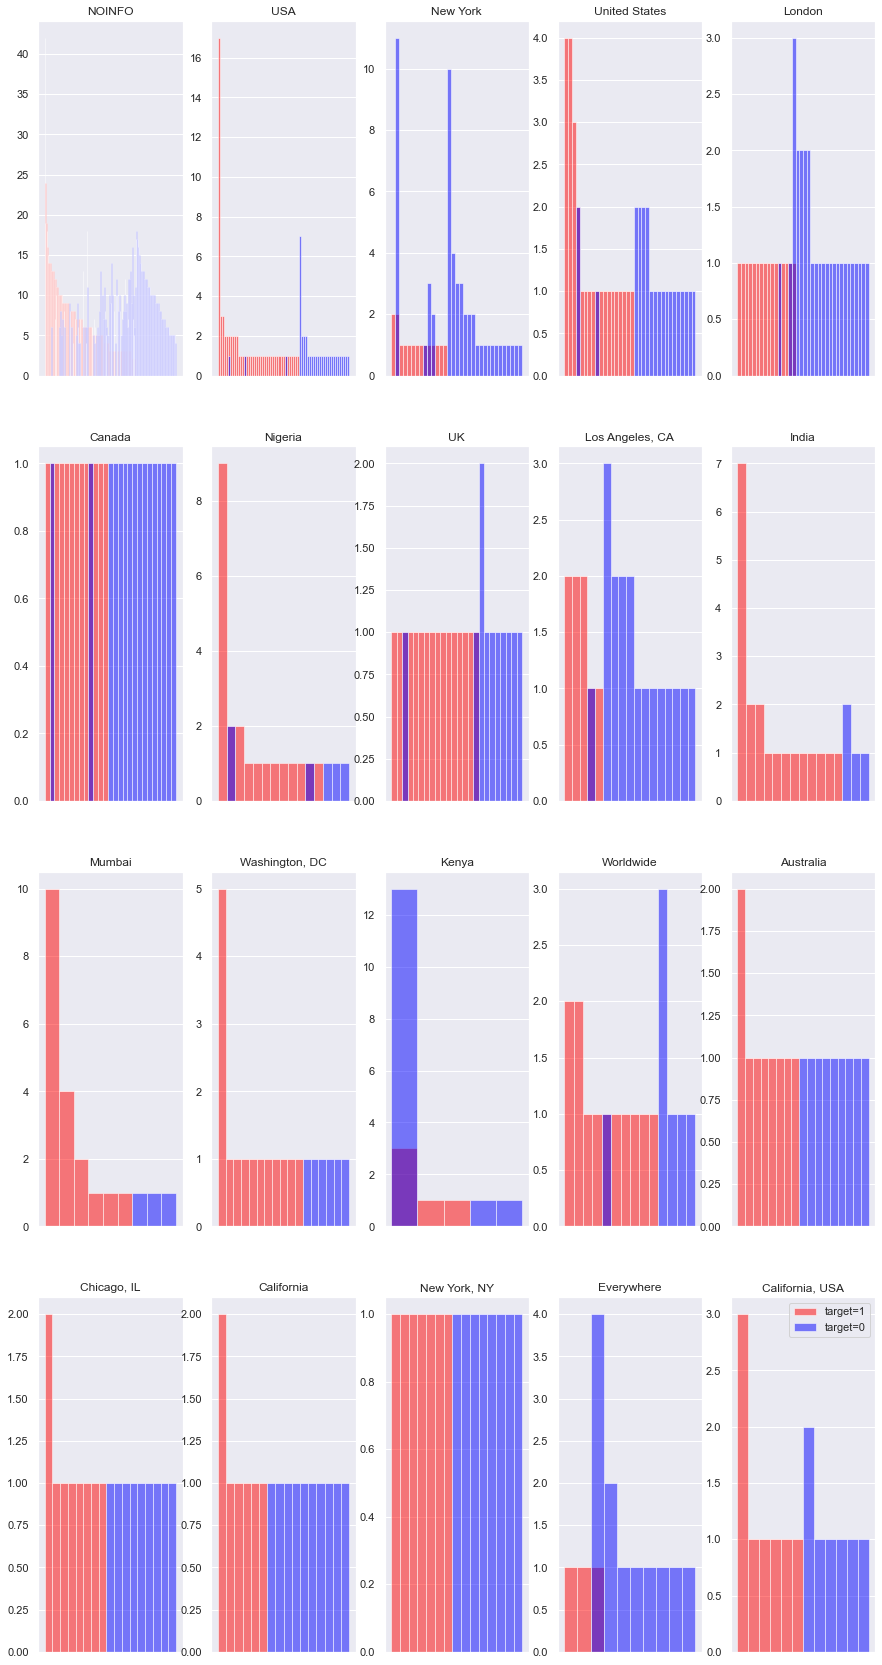

In [18]:
top_keywords = 150

freq_locations = list(train_for_plot['location'].value_counts(dropna=False)[:20].index)
fig, axes = plt.subplots(4, 5, figsize=(15, 30))
plt.xticks(rotation=90)
for ax, loc in zip(axes.reshape(-1), freq_locations):
    ax.set_title(loc)
    ax.get_xaxis().set_visible(False)
    ax.bar(train_for_plot[(train_for_plot['target'] == 1) & (train_for_plot['location'] == loc)]
           ['keyword'].value_counts().index[:top_keywords],
        train_for_plot[(train_for_plot['target'] == 1) & (train_for_plot['location'] == loc)]
           ['keyword'].value_counts().values[:top_keywords],
        width=1, alpha=0.5, color='red', label='target=1')
    ax.bar(train_for_plot[(train_for_plot['target'] == 0) & (train_for_plot['location'] == loc)]
           ['keyword'].value_counts().index[:top_keywords],
        train_for_plot[(train_for_plot['target'] == 0) & (train_for_plot['location'] == loc)]
           ['keyword'].value_counts().values[:top_keywords],
        width=1, alpha=0.5, color='blue', label='target=0')
plt.legend()

## Simple linear models using two features

In [19]:
np.random.seed(144)

train.fillna('noinfo', inplace=True)
test.fillna('noinfo', inplace=True)

### Logistic Regression

In [20]:
shuffled_train = train.iloc[np.random.permutation(len(train))]

In [21]:
max_iter = 100
cv = 5
#regularization
Cs=[0.1, 0.2, 0.4, 0.6, 1]

Log = LogisticRegression(n_jobs = -1)

parameters = {'C': Cs, 'penalty': ('l2', 'none')}
clf = GridSearchCV(Log, parameters, scoring='f1', cv=cv)

X = shuffled_train[['location', 'keyword']]
Y = shuffled_train['target']
enc = OneHotEncoder()
X = enc.fit_transform(X)

clf.fit(X,Y)

print(clf.best_estimator_)
print('Best CV score:')
print(clf.best_score_)

C:\ProgramData\Anaconda3_1\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=0.1, n_jobs=-1, penalty='none')
Best CV score:
0.6722162240118548


### Bernoulli Naive Bayes

In [22]:
NB = BernoulliNB()

parameters = {'fit_prior': [True, False], 'alpha': [0.25, 0.5, 1, 1.5]}
clf = GridSearchCV(NB, parameters, scoring='f1', cv=cv)

X = shuffled_train[['location', 'keyword']]
Y = shuffled_train['target']
enc = OneHotEncoder()
X = enc.fit_transform(X)

clf.fit(X,Y)

print(clf.best_estimator_)
print('Best CV score:')
print(clf.best_score_)

BernoulliNB(alpha=1, fit_prior=False)
Best CV score:
0.6954745377661038


The results are not hight enough, so we'll use these them as baseline.

## Creating metafeatures from 'text' feature

**Mentions (@) count**

In [23]:
train['mentions_count'] = train['text'].apply(lambda x: x.count('@'))
test['mentions_count'] = test['text'].apply(lambda x: x.count('@'))

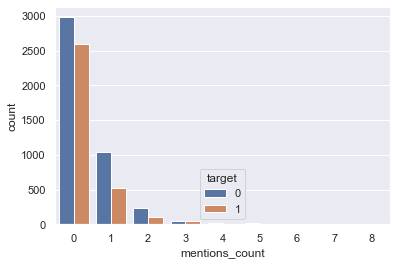

In [24]:
sns.countplot(x='mentions_count', hue='target', data = train)

mentions_count_binary = 1 if mentions_count > 0, else 0

In [25]:
train['mentions_count_bin'] = train['mentions_count'].apply(lambda x: 1 if x > 0 else 0)
test['mentions_count_bin'] = test['mentions_count'].apply(lambda x: 1 if x > 0 else 0)

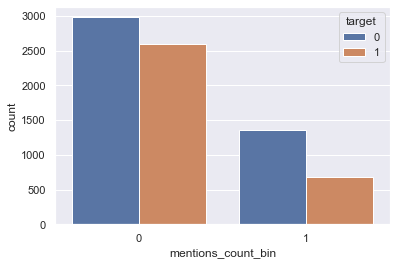

In [26]:
sns.countplot(x='mentions_count_bin', hue='target', data = train)

**Links count**

In [27]:
train['links_count'] = train['text'].apply(lambda x: x.count('https'))
test['links_count'] = test['text'].apply(lambda x: x.count('https'))

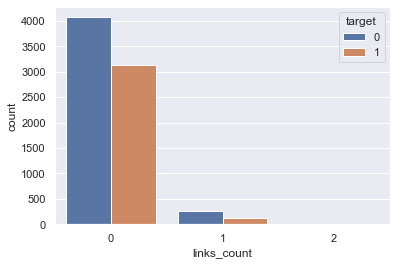

In [28]:
sns.countplot(x='links_count', hue='target', data = train)

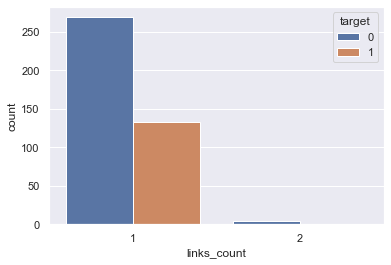

In [29]:
sns.countplot(x='links_count', hue='target', data = train[train['links_count'] > 0])

links_count_binary = 1 if links_count > 0 else 0

In [30]:
train['links_count_bin'] = train['links_count'].apply(lambda x: 1 if x > 0 else 0)
test['links_count_bin'] = test['links_count'].apply(lambda x: 1 if x > 0 else 0)

**Punctuation marks count**

In [31]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

train['punctuation_count'] = train['text'].apply(lambda x: count(x , string.punctuation))
test['punctuation_count'] = test['text'].apply(lambda x: count(x , string.punctuation))

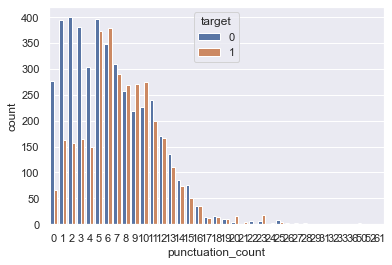

In [32]:
sns.countplot(x='punctuation_count', hue='target', data = train)

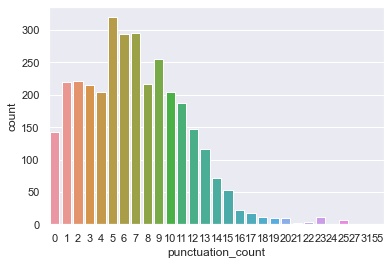

In [33]:
sns.countplot(x='punctuation_count', data = test)

In [34]:
train['punctuation_count'].describe()

count    7613.000000
mean        6.839485
std         4.608758
min         0.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        61.000000
Name: punctuation_count, dtype: float64

In [35]:
test['punctuation_count'].describe()

count    3263.000000
mean        6.950659
std         4.486544
min         0.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        55.000000
Name: punctuation_count, dtype: float64

In [36]:
train.loc[train['punctuation_count'] > 16, 'punctuation_count'] = 16
test.loc[test['punctuation_count'] > 16, 'punctuation_count'] = 16

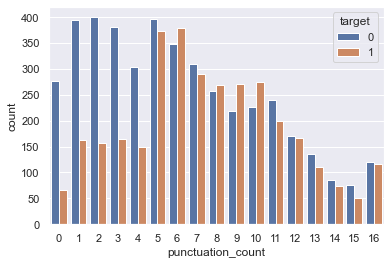

In [37]:
sns.countplot(x='punctuation_count', hue='target', data = train)

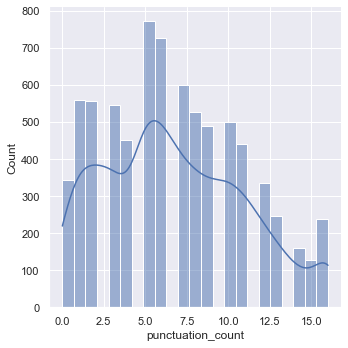

In [38]:
sns.displot(train['punctuation_count'], kde=True)

**Punctuation_count scaling**

In [39]:
scaler = MinMaxScaler()

In [40]:
train['punctuation_count'] = scaler.fit_transform(train[['punctuation_count']])
test['punctuation_count'] = scaler.fit_transform(test[['punctuation_count']])

### Text cleaning and transforming

**Lowercase**

In [41]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

**Removing links and mentions (@somebody)**

In [42]:
train['text'] = train['text'].apply(lambda x:
                                    re.sub(r'https?://\S+|www\.\S+','', x))
test['text'] = test['text'].apply(lambda x:
                                    re.sub(r'https?://\S+|www\.\S+','', x))

In [43]:
train['text'] = train['text'].apply(lambda x:
                                    re.sub(r'@[A-Za-z0-9]+','', x))
test['text'] = test['text'].apply(lambda x:
                                    re.sub(r'@[A-Za-z0-9]+','', x))
train['text'] = train['text'].apply(lambda x:
                                    re.sub(r'#','', x))
test['text'] = test['text'].apply(lambda x:
                                    re.sub(r'#','', x))

**Removing punctuation**

In [44]:
train['text'] = train['text'].apply(lambda x:
                                   re.sub(r'[^\w\s]','', x))
test['text'] = test['text'].apply(lambda x:
                                   re.sub(r'[^\w\s]','', x))

**Lemmatizing text**

In [45]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

train['text'] = train.text.apply(lambda x: lemmatize_text(x))
test['text'] = test.text.apply(lambda x: lemmatize_text(x))

**Stopwords analyze**

In [46]:
from nltk.corpus import stopwords
all_stopwords = set(stopwords.words('english'))

In [47]:
def stopword_count(data, column):
    count_dict = dict.fromkeys(all_stopwords, 0)
    def row_count(row):
        for word in row.split():
            if word in all_stopwords:
                count_dict[str(word)] += 1
    data[column].apply(lambda x: row_count(x))
    return count_dict

In [48]:
stopwords = stopword_count(train, 'text')
stopwords = pd.Series(stopwords, index=stopwords.keys())
stopwords = stopwords[stopwords > 0]
stopwords = stopwords.sort_values(ascending=False)

#### Most popular stopwords

<BarContainer object of 40 artists>

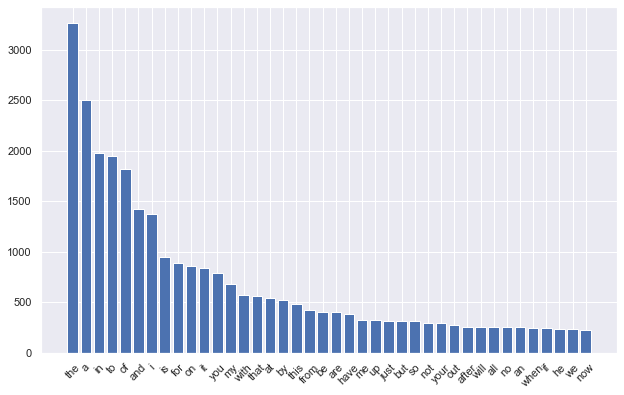

In [49]:
top = 40
fig= plt.figure(figsize=(10,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.xticks(rotation=45)
#axes.get_xaxis().set_visible(False)
plt.bar(stopwords[:top].index, stopwords[:top].values)

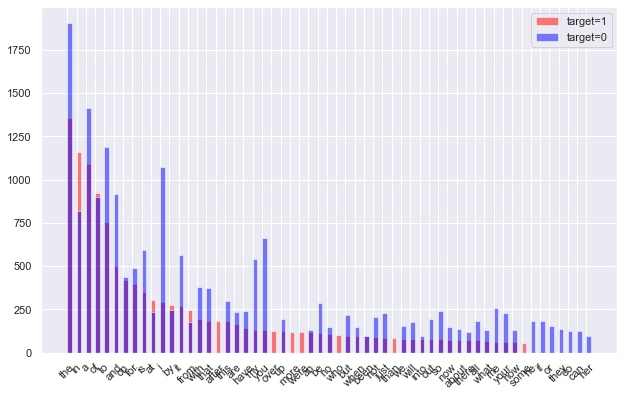

In [50]:
stopwords_1 = stopword_count(train[train['target'] == 1], 'text')
stopwords_1 = pd.Series(stopwords_1, index=stopwords.keys())
stopwords_1 = stopwords_1[stopwords_1 > 0]
stopwords_1 = stopwords_1.sort_values(ascending=False)
stopwords_0 = stopword_count(train[train['target'] == 0], 'text')
stopwords_0 = pd.Series(stopwords_0, index=stopwords.keys())
stopwords_0 = stopwords_0[stopwords_0 > 0]
stopwords_0 = stopwords_0.sort_values(ascending=False)

top = 50
fig= plt.figure(figsize=(10,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
plt.xticks(rotation=45)
#axes.get_xaxis().set_visible(False)
axes.bar(stopwords_1[:top].index, stopwords_1[:top].values, 
        width=0.5, alpha=0.5, color='red', label='target=1', align='edge')
axes.bar(stopwords_0[:top].index, stopwords_0[:top].values, 
        width=0.5, alpha=0.5, color='blue', label='target=0', align='edge')
plt.legend()

**Not removing stopwords**

## TF-IDF Vectorization

In [51]:
vect = TfidfVectorizer(min_df=4, ngram_range=(1,1))
enc = OneHotEncoder()

full_data = pd.concat((train, test))

enc.fit(full_data[['location', 'keyword']])
vect.fit(full_data['text'])
print(len(vect.get_feature_names()))
print(len(enc.get_feature_names()))

4058
256


## Methods using all features

In [52]:
np.random.seed(144)
shuffled_train = train.iloc[np.random.permutation(len(train))]

X_meta = np.array(shuffled_train[['mentions_count_bin', 'links_count_bin', 'punctuation_count']])
X_vect = vect.transform(shuffled_train['text']).todense()
X_onehot = enc.transform(shuffled_train[['location', 'keyword']]).todense()
X = np.concatenate((X_vect, X_onehot, X_meta), axis=1)
Y = shuffled_train['target']

### Random forest

In [54]:
n_estimators = [800]
max_features = ['sqrt']
cv = 3

RF = RandomForestClassifier(n_jobs = -1, max_samples=0.6)

parameters = {'n_estimators':n_estimators, 'max_features':max_features}
RF_clf = GridSearchCV(RF, parameters, scoring='f1', cv=cv, verbose=1)

RF_clf.fit(X,Y)

print(RF_clf.best_estimator_)
print('Best CV score')
print(RF_clf.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min finished


RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=800,
                       n_jobs=-1)
Best CV score
0.7189670087365089


### Naive Bayes

**Multinomial**

In [53]:
cv = 5

X_sparsed = sparse.csr_matrix(X[:, :-1])

MNB = MultinomialNB()

parameters = {'fit_prior': [True, False], 'alpha':[0.2, 0.5, 1]}

MNB_clf = GridSearchCV(MNB, parameters, scoring='f1', cv=cv)

#Without punctuation count (it's not bernoulli dist)
MNB_clf.fit(X_sparsed,Y)

print(MNB_clf.best_estimator_)
print('Best CV score')
print(MNB_clf.best_score_)

MultinomialNB(alpha=0.2)
Best CV score
0.7597326720328393


**Bernoulli**

In [54]:
cv = 5

X_sparsed = sparse.csr_matrix(X[:, :-1])

BNB = BernoulliNB()

parameters = {'fit_prior': [True, False], 'binarize': [0, 0.2, 0.5], 'alpha':[0.2, 0.5, 1]}

BNB_clf = GridSearchCV(BNB, parameters, scoring='f1', cv=cv)

#Without punctuation count (it's not bernulli dist)
BNB_clf.fit(X_sparsed,Y)

print(BNB_clf.best_estimator_)
print('Best CV score')
print(BNB_clf.best_score_)

BernoulliNB(alpha=1, binarize=0.2, fit_prior=False)
Best CV score
0.7645915634751856


### Logistic Regression

In [55]:
cv = 5
Cs = [0.2, 0.5, 1]

X_sparsed = sparse.csr_matrix(X)

Log = LogisticRegression(n_jobs = -1)

parameters = {'C': Cs, 'penalty': ['l2', 'none']}
Log_clf = GridSearchCV(Log, parameters, scoring='f1', cv=cv)

Log_clf.fit(X_sparsed, Y)

print(Log_clf.best_estimator_)
print('Best CV score')
print(Log_clf.best_score_)

C:\ProgramData\Anaconda3_1\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


LogisticRegression(C=1, n_jobs=-1)
Best CV score
0.7526387786153679


### Support Vector Machine

In [56]:
max_iter = 5000
Cs = [0.1, 0.2, 0.25, 0.5, 1]
loss = ('hinge', 'squared_hinge')
penalty = ('l2', 'l1')

X_sparsed = sparse.csr_matrix(X)

SVC = LinearSVC(max_iter = max_iter, dual = False)

parameters = {'C': Cs, 'loss': loss}
SVC_clf = GridSearchCV(SVC, parameters, scoring='f1', cv=cv)

SVC_clf.fit(X_sparsed, Y)

print(SVC_clf.best_estimator_)
print('Best CV score')
print(SVC_clf.best_score_)

C:\ProgramData\Anaconda3_1\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3_1\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3_1\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\ProgramData\Anaconda3_1\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\ProgramData\Anaconda3_1\lib\site-packages\sklearn\svm\_base.py", line 821, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination

LinearSVC(C=0.2, dual=False, max_iter=5000)
Best CV score
0.7564976700505632


## Making predictions

In [57]:
from datetime import datetime

We'll use an ensamble of LogRegression, Naive Bayes

### Test vectorization

In [58]:
X_meta_test = np.array(test[['mentions_count_bin', 'links_count_bin', 'punctuation_count']])

In [59]:
np.random.seed(144)

X_vect_test = vect.transform(test['text']).todense()
X_onehot_test = enc.transform(test[['location', 'keyword']]).todense()
X_test = np.concatenate((X_vect_test, X_onehot_test, X_meta_test), axis=1)

In [60]:
X_sparsed = sparse.csr_matrix(X)
X_sparsed_test = sparse.csr_matrix(X_test)

### LogRegression

In [61]:
Log_clf.best_params_

{'C': 1, 'penalty': 'l2'}

In [62]:
Log_clf_final = LogisticRegression(C = 1, penalty = 'l2', n_jobs=-1)

start = datetime.now()
Log_clf_final.fit(X_sparsed, Y)

print('Training time')
print(datetime.now() - start)

start = datetime.now()
LogReg_predict = Log_clf_final.predict(X_sparsed_test)

print('Predicting time')
print(datetime.now() - start)

Training time
0:00:00.106715
Predicting time
0:00:00.000996


### Bernoulli Naive Bayes

In [63]:
BNB_clf.best_params_

{'alpha': 1, 'binarize': 0.2, 'fit_prior': False}

In [64]:
BNB_clf_final = BernoulliNB(alpha = 1, binarize = 0, fit_prior = False)

start = datetime.now()
BNB_clf_final.fit(X_sparsed, Y)

print('Training time')
print(datetime.now() - start)

start = datetime.now()
BNB_predict = BNB_clf_final.predict(X_sparsed_test)

print('Predicting time')
print(datetime.now() - start)

Training time
0:00:00.003964
Predicting time
0:00:00.000997


### Multinomial Naive Bayes

In [65]:
MNB_clf.best_params_

{'alpha': 0.2, 'fit_prior': True}

In [66]:
MNB_clf_final = MultinomialNB(alpha = 0.5,fit_prior = False)

start = datetime.now()
MNB_clf_final.fit(X_sparsed, Y)

print('Training time')
print(datetime.now() - start)

start = datetime.now()
MNB_predict = MNB_clf_final.predict(X_sparsed_test)

print('Predicting time')
print(datetime.now() - start)

Training time
0:00:00.004004
Predicting time
0:00:00.001411


In [67]:
MNB_predict

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

### Support Vector Machine

In [68]:
SVC_clf.best_params_

{'C': 0.2, 'loss': 'squared_hinge'}

In [69]:
SVC_clf_final = LinearSVC(C = 0.2, loss='squared_hinge', max_iter = 5000)

start = datetime.now()
SVC_clf_final.fit(X_sparsed, Y)

print('Training time')
print(datetime.now() - start)

start = datetime.now()
SVC_predict = SVC_clf_final.predict(X_sparsed_test)

print('Predicting time')
print(datetime.now() - start)

Training time
0:00:00.019919
Predicting time
0:00:00.001055


### Voting Classifier from MNB, BNB and Log Reg

In [70]:
ens_clf = VotingClassifier(voting='soft', estimators = [('BNB', BNB_clf_final), ('MNB', MNB_clf_final), 
                                                       ('LogReg', Log_clf_final)])

In [71]:
ens_clf.fit(X_sparsed, Y)
ens_predict = ens_clf.predict(X_sparsed_test)

In [72]:
for name, predict in [('LogReg', LogReg_predict), ('MNB', MNB_predict),
                      ('BNB', BNB_predict), ('SVM', SVC_predict),
                     ('Ensamble', ens_predict)]:
    result_df = pd.DataFrame(test['id'].values, columns=['id']) 
    result_df['target'] = predict.astype(int)
    result_df.to_csv(path_or_buf=r'./disaster_tweets/submission_' + name + '.csv', index=False)

**Saving trained models without using 'location' and 'keyword' features for future using**

In [73]:
X_meta = np.array(train[['mentions_count_bin', 'links_count_bin', 'punctuation_count']])
X_vect = vect.transform(train['text']).todense()
X = np.concatenate((X_vect, X_meta), axis=1)
Y = train['target']

In [89]:
Log_clf = LogisticRegression(C = 1, penalty = 'l2', n_jobs=-1)
Log_clf.fit(X, Y)

BNB_clf = BernoulliNB(alpha = 1, binarize = 0, fit_prior = False)
BNB_clf.fit(X, Y)

MNB_clf = MultinomialNB(alpha = 0.5,fit_prior = False)
MNB_clf.fit(X, Y)

ens_clf = VotingClassifier(voting='soft', estimators = [('BNB', Log_clf), ('MNB', BNB_clf), 
                                                       ('LogReg', MNB_clf)])
ens_clf.fit(X, Y)

VotingClassifier(estimators=[('BNB', LogisticRegression(C=1, n_jobs=-1)),
                             ('MNB',
                              BernoulliNB(alpha=1, binarize=0,
                                          fit_prior=False)),
                             ('LogReg',
                              MultinomialNB(alpha=0.5, fit_prior=False))],
                 voting='soft')

In [90]:
pickle.dump(Log_clf, open(r'disaster_tweets/models/LogReg_model.sav', 'wb'))
pickle.dump(BNB_clf, open(r'disaster_tweets/models/BNB_model.sav', 'wb'))
pickle.dump(MNB_clf, open(r'disaster_tweets/models/MNB_model.sav', 'wb'))
pickle.dump(ens_clf, open(r'disaster_tweets/models/ens_model.sav', 'wb'))
pickle.dump(vect, open(r'disaster_tweets/models/vectorizer.sav', 'wb'))